<a href="https://githubtocolab.com/geonextgis/cropengine/blob/main/docs/examples/Run wofost (single location).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Uncomment the following line to install the latest version of [cropengine](https://geonextgis.github.io/cropengine) if needed.

In [1]:
# !pip install -U cropengine

## Import libraries

In [2]:
import os
import pandas as pd
import seaborn as sns
from cropengine import WOFOSTCropSimulationRunner
from cropengine.agromanagement import WOFOSTAgroEventBuilder

## User inputs

## Instantiate crop simulation engine for WOFOST

In [3]:
# Define the model name
MODEL_NAME = "Wofost72_WLP_CWB"

# Initialize Engine
runner = WOFOSTCropSimulationRunner(
    model_name=MODEL_NAME, workspace_dir="test_output/location_workspace"
)

In [4]:
# Location
LATITUDE = 53.3721
LONGITUDE = 13.82299

# Crop Configuration
# Note: Use runner.get_..._options() to see valid values if unsure
models = runner.get_model_options()
crops = runner.get_crop_options(MODEL_NAME)
CROP_NAME = "sugarbeet"
varieties = runner.get_variety_options(MODEL_NAME, CROP_NAME)
CROP_VARIETY = "Sugarbeet_601"

# Timing
crop_start_end = runner.get_crop_start_end_options()
CAMPAIGN_START = "2006-01-01"
CROP_START = "2006-04-05"
CROP_START_TYPE = "emergence"
CROP_END_TYPE = "harvest"
CROP_END = "2006-10-20"
CAMPAIGN_END = "2007-01-01"
MAX_DURATION = 300

## Create agromanagements with user inputs

In [5]:
agro_event_builder = WOFOSTAgroEventBuilder()

# Note: Use agro_event_builder.get_..._events_info() to see valid values if unsure
timed_events_info = agro_event_builder.get_timed_events_info()
state_events_info = agro_event_builder.get_state_events_info()

# Build timed events (irrigation)
irrigation_schedule = [
    {"event_date": "2006-05-25", "amount": 3.0, "efficiency": 0.7},
    {"event_date": "2006-06-30", "amount": 2.5, "efficiency": 0.7},
]

irrigation_events = agro_event_builder.create_timed_events(
    signal_type="irrigate", events_list=irrigation_schedule
)

# Build state Events (fertilization based on DVS)
nitrogen_schedule = [
    {"threshold": 0.3, "N_amount": 40, "N_recovery": 0.7},
    {"threshold": 0.6, "N_amount": 60, "N_recovery": 0.7},
    {"threshold": 1.12, "N_amount": 40, "N_recovery": 0.7},
]

nitrogen_events = agro_event_builder.create_state_events(
    signal_type="apply_n",
    state_var="DVS",
    zero_condition="rising",
    events_list=nitrogen_schedule,
)

## Prepare system (must be implemented before running the simulation)

In [9]:
runner.prepare_system(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    campaign_start=CAMPAIGN_START,
    campaign_end=CAMPAIGN_END,
    crop_start=CROP_START,
    crop_start_type=CROP_START_TYPE,
    crop_end_type=CROP_END_TYPE,
    crop_end=CROP_END,
    max_duration=MAX_DURATION,
    crop_name=CROP_NAME,
    variety_name=CROP_VARIETY,
    timed_events=[irrigation_events],
    state_events=[nitrogen_events],
    force_update=False,
    force_param_update=True,
    site_overrides={'WAV': 10}  # Extra site params can be passed as overrides
)

[PREP] Preparing workspace: test_output/location_workspace
[PREP] Using existing Agromanagement config.
[PREP] System Ready.


## Get the parameters table to be displayed in the dashboard

### Soil parameters

In [10]:
soil_params = pd.read_csv(
    runner.files["soil_params"]
)
print(soil_params.shape)
soil_params.head()

(46, 4)


,parameter,description,unit,value
0,A0SOM,Initial age of soil organic material,year,NaN
1,BG_N_SUPPLY,Background supply of N through atmospheric dep...,kg/ha/day,NaN
2,CNRatioBio,C:N ratio of microbial biomass,kg C kg-1 N,NaN
3,CNRatioSOMI,Initial C:N ratio of soil organic matter,kg C kg-1 N,0.98
4,CONDfromPF,Table function of the 10-base logarithm of the...,log10(cm water d-1),NaN


In [11]:
site_params = pd.read_csv(
    runner.files["site_params"]
)
print(site_params.shape)
site_params.head()

(6, 8)


,parameter,required,value,default,range,type,description,unit
0,IFUNRN,False,0.0,0.0,"[0, 1]",int,Indicates whether non-infiltrating fraction of...,-
1,NOTINF,False,0.0,0.0,"[0.0, 1.0]",float,Maximum fraction of rain not-infiltrating into...,-
2,SMLIM,False,0.4,0.4,"[0.0, 1.0]",float,Initial maximum moisture content in initial ro...,-
3,SSI,False,0.0,0.0,"[0.0, 100.0]",float,Initial depth of water stored on the surface.,cm
4,SSMAX,False,0.0,0.0,"[0.0, 100.0]",float,Maximum depth of water that can be stored on t...,cm


In [12]:
crop_params = pd.read_csv(
    runner.files["crop_params"]
)
print(crop_params.shape)
crop_params.head()

(94, 5)


,parameter,description,unit,required,value
0,AMAXTB,maximum leaf CO2 assimilation rate as function...,"['-', 'kg.ha-1.hr-1']",False,"[0.0, 22.5, 1.0, 45.0, 1.13, 45.0, 1.8, 36.0, ..."
1,CFET,correction factor transpiration rate,-,False,1.0
2,CO2AMAXTB,multiplication factor for AMAX to account for ...,"['PPM', '-']",False,"[40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1...."
3,CO2EFFTB,multiplication factor for EFF to account for a...,"['PPM', '-']",False,"[40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1..."
4,CO2TRATB,multiplication factor for maximum transpiratio...,"['PPM', '-']",False,"[40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0...."


## Run the Simulation

In [13]:
simulation_output = runner.run_simulation(
    soil_overrides=None,  # Runtime soil params can be passed as overrides
    site_overrides=None,  # Runtime site parameters can be passed as overrides
    crop_overrides=None,  # Runtime crop parameters can be passed as overrides
    agro_file_path=None,  # Runtime agro_file_path if any
)

# Set day as index
simulation_output = simulation_output.set_index("day")
print(simulation_output.shape)
simulation_output.head()

[RUN] Initializing Wofost72_WLP_CWB in test_output/location_workspace...
(366, 12)


,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,RFTRA
day,,,,,,,,,,,,
2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40000,22.000000,NaN
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31555,22.154351,NaN
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30077,22.162051,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31455,22.307551,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30721,22.379651,NaN


## Plot the simulation output

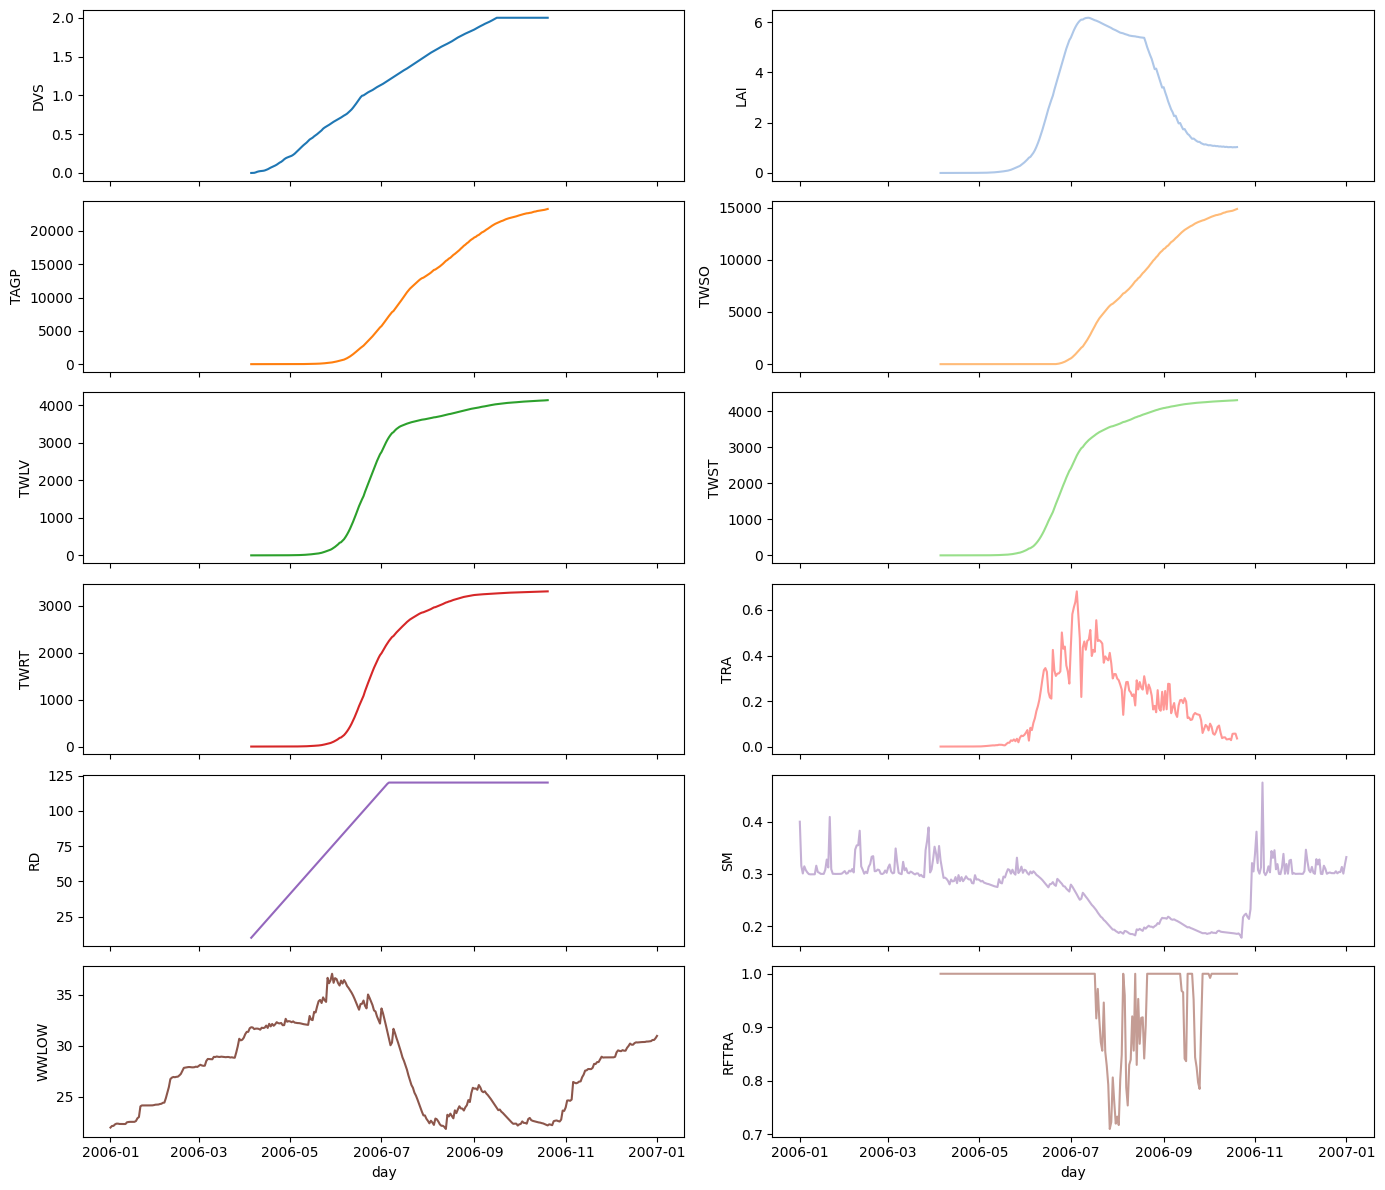

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Variables
cols = 2
n_vars = len(simulation_output.columns)
rows = math.ceil(n_vars / cols)

# Use a categorical color palette large enough
palette = sns.color_palette("tab20", n_vars)

fig, axes = plt.subplots(rows, cols, figsize=(14, 2 * rows), sharex=True)
axes = np.array(axes).reshape(-1)

for i, var in enumerate(simulation_output.columns):
    sns.lineplot(
        x=simulation_output.index,
        y=simulation_output[var],
        ax=axes[i],
        color=palette[i],
    )

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()